In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

In [3]:
path = 'data/minimal_pkls/'
save_path = 'data/phi_stats/'
os.makedirs(save_path, exist_ok=True)
len(os.listdir(path))

201

In [71]:
from social_phi import get_signal, experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def run_experiment(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.csv'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    stats.to_csv(save_path + file[:-4] + '.csv', index=False)
    
    
def load_data(file):
    stats = pd.read_csv(save_path + file[:-4] + '.csv')
    data = pickle.load(open(path + file, 'rb'))
    act = flatten(data['activities'].values())
    
    res = {
        'forks' : data['forks'],
        'stars' : data['stars'],
        'open_issues' : np.sum(data['issues_state']),
        'closed_issues' : len(data['issues_state']) - np.sum(data['issues_state']),
        'avg_issue_survival' : np.mean(data['issues_lifetime']),
        'users' : len(data['activities']),
        'total_commits' : len(act),
        'age' : (max(act) - min(act)) // (24*3600),
        'linear_avg_phi' : stats.linear_avg_phi[np.argmax(stats.linear_avg_phi)],
        'zeroed_avg_phi' : stats.zeroed_avg_phi[np.argmax(stats.zeroed_avg_phi)],
        'raw_avg_phi' : stats.raw_avg_phi[np.argmax(stats.raw_avg_phi)]
        
    }
#     res['avg_commit_per_day'] = res['total_commits'] / res['timeline_length']
#     res['avg_commit_per_user'] = res['total_commits'] / res['users']
#     res['closed_open_ratio'] = res['closed_issues'] / res['open_issues'] if res['open_issues'] > 0 else 0.
    return res

In [16]:
# from joblib import Parallel, delayed

# _ = Parallel(n_jobs=20)(delayed(run_experiment)(file) for file in tqdm(os.listdir(path)))

In [72]:
df = pd.DataFrame(
    columns=[
        'forks', 'stars', 'users', 
        'total_commits', 'age',#'avg_commit_per_day', 'avg_commit_per_user',
        'open_issues', 'closed_issues', 'avg_issue_survival',#'closed_open_ratio',
        'linear_avg_phi', 'zeroed_avg_phi', 'raw_avg_phi'
    ]
)

for file in os.listdir(path):
    try:
        df = df.append(load_data(file), ignore_index=True)
    except Exception as e:
        print(file, e)
df = df.astype(float)
print(df.shape)
df.describe()

golang____go.pkl [Errno 2] No such file or directory: 'data/phi_stats/golang____go.csv'
(200, 11)


,forks,stars,users,total_commits,age,open_issues,closed_issues,avg_issue_survival,linear_avg_phi,zeroed_avg_phi,raw_avg_phi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,7310.725000,34761.095000,626.325000,10420.275000,2897.120000,751.060000,10413.280000,114.900067,1.090646,0.083392,1.283914
std,8987.707573,32779.152061,837.297933,5509.547699,1182.043621,975.378657,9018.750499,112.082470,0.151689,0.029422,0.269464
min,719.000000,15237.000000,11.000000,1520.000000,414.000000,0.000000,504.000000,3.163547,0.744462,0.002807,0.806184
25%,2934.000000,18782.000000,247.000000,6215.250000,2127.000000,158.750000,4820.500000,39.846452,0.998215,0.065582,1.103196
50%,4426.500000,24287.500000,455.500000,8448.000000,2737.000000,502.500000,8334.500000,81.723641,1.067932,0.078725,1.227215
75%,7774.500000,37941.500000,714.500000,13560.750000,3599.250000,913.750000,12588.500000,146.399293,1.174121,0.096563,1.406372
max,73734.000000,325401.000000,9618.000000,27770.000000,7847.000000,9239.000000,75807.000000,643.970195,1.605751,0.267149,2.678072


## issue survival analysis

In [221]:
# all_issues_lifetime = []
# for file in os.listdir(path):
#     if '____' in file:
#         data = pickle.load(open(path + file, 'rb'))
#         all_issues_lifetime += [data['issues_lifetime']]

# m = min(flatten(all_issues_lifetime))
# M = max(flatten(all_issues_lifetime))
# n_bins = 1000
# issue_bins = np.linspace(m, M + 1, n_bins + 1)
# issues_survival = np.array([np.histogram(lifetime, issue_bins)[0] for lifetime in all_issues_lifetime])
# mean_issues_survival = np.array([np.mean(lifetime) for lifetime in all_issues_lifetime])

# scale = MinMaxScaler()
# # #StandardScaler()

# pca = PCA(n_components=1).fit(issues_survival)
# # cum_var = np.cumsum(pca.explained_variance_ratio_)
# issue_life_comps = pca.transform(issues_survival)
# # print(cum_var[-1])

# # plt.figure(figsize=(20,5))
# # plt.subplot(1,2,1)
# # plt.title('pc1')
# scaled_comps = scale.fit_transform(issue_life_comps)
# # plt.hist(scaled_comps, 100)

# # plt.subplot(1,2,2)
# # plt.title('mean')
# scaled_means = scale.fit_transform(mean_issues_survival.reshape(-1,1))
# # plt.hist(scaled_means, 100)
# # print('means var:',np.var(scaled_means), ' comps var:', np.var(scaled_comps))
# # # plt.scatter(issue_life_comps[:,0], issue_life_comps[:,1])
# # plt.show()

In [63]:
# bins = 20
# n = len(df.columns)

# plt.figure(figsize=(15,n*2))
# for i,col in enumerate(df.columns):
#     plt.subplot(int(np.round(n/2)), 2, i+1)
#     plt.title(col)
#     plt.hist(df[col], bins)

# plt.show()

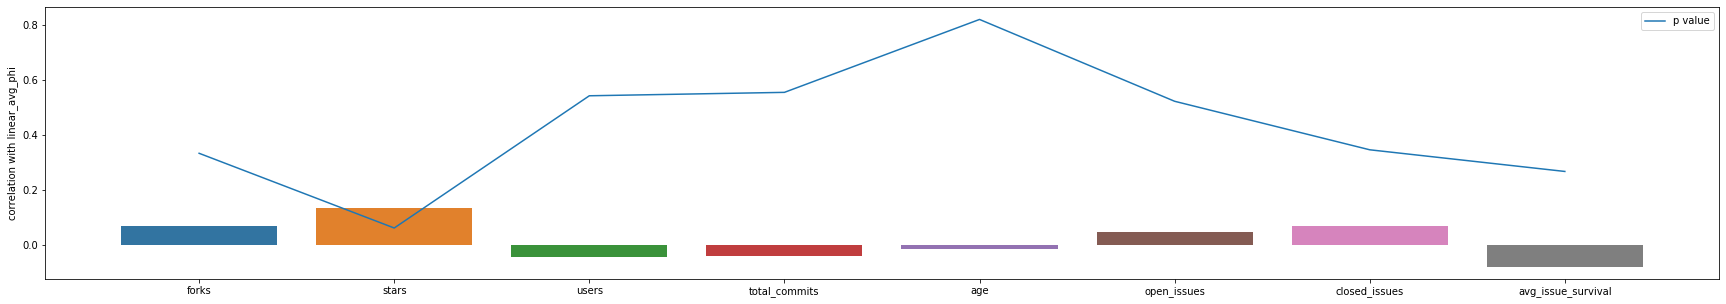

In [73]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score


corrs = df.corr(method='pearson') # spearman , kendall
corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)

plt.figure(figsize=(30,5))
# plt.subplot(3,1,1)
# sns.barplot(y=corrs['raw_avg_phi'], x=df.columns)
# plt.plot(corr_pvals['raw_avg_phi'], label='p value')
# plt.ylabel('correlation with raw_avg_phi')
# plt.subplot(3,1,2)
# sns.barplot(y=corrs['zeroed_avg_phi'], x=df.columns)
# plt.plot(corr_pvals['zeroed_avg_phi'], label='p value')
# plt.ylabel('correlation with zeroed_avg_phi')
# plt.subplot(3,1,3)
cols2drop = list(filter(lambda x: x.endswith('phi'), df.columns))
sns.barplot(y=corrs.drop(cols2drop, axis=1).loc['linear_avg_phi'], x=df.drop(cols2drop, axis=1).columns)
plt.plot(corr_pvals.drop(cols2drop, axis=1).loc['linear_avg_phi'], label='p value')
plt.ylabel('correlation with linear_avg_phi')
plt.legend()
plt.show()

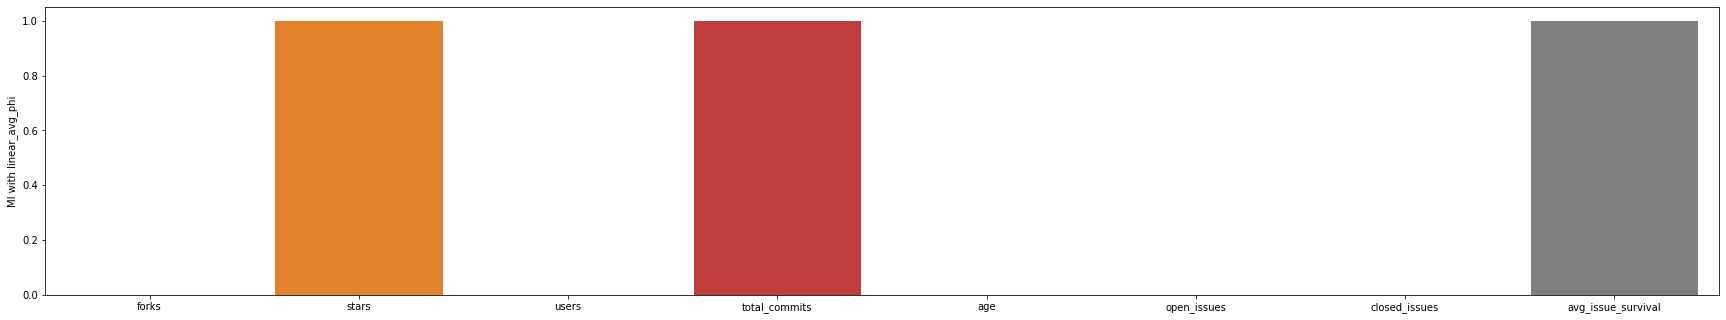

In [74]:
def get_mi(trg_col):
    mis = np.zeros(shape=df.shape[1]-3)
    cols2drop = list(filter(lambda x: x.endswith('phi'), df.columns))
    for i,col in enumerate(df.drop(cols2drop, axis=1).columns):
        mis[i] = adjusted_mutual_info_score(df[trg_col], df[col])

    sns.barplot(y=mis, x=df.drop(cols2drop, axis=1).columns)
    plt.ylabel(f'MI with {trg_col}')

plt.figure(figsize=(30,18))
for i,col in enumerate(['linear_avg_phi']):#'raw_avg_phi', 'zeroed_avg_phi', 
    plt.subplot(3,1,i+1)
    get_mi(col)
plt.show()

In [271]:
# def quantize_col(data, col, n_bins=5):
#     bins = np.linspace(np.min(data[col]), np.max(data[col])+1, n_bins+1)
#     temp_df = data.copy()[[col, 'avg_phi']]
#     temp_df[col+'_quantized'] = np.digitize(temp_df[col], bins=bins)   
#     sns.boxplot(data=temp_df, x=col+'_quantized', y='avg_phi')

# n = len(df.columns) - 1
# plt.figure(figsize=(20,n*2))
# for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
#     plt.subplot(n // 2 +1, 2, i+1)
#     quantize_col(df, col, n_bins=5)
# plt.show()

In [44]:
def get_scatter_regression(trg_col):
    n = len(df.columns) - 1
    standardize = lambda v : (v - v.mean()) / v.std()
#     standardize = lambda v : v
    x = standardize(df[trg_col].values)
    cols2drop = list(filter(lambda x: x.endswith('phi'), df.columns))

    plt.figure(figsize=(16,n*2))
    for i,col in enumerate(df.drop(cols2drop, axis=1).columns):
        y = standardize(df[col].values)
        lr = LinearRegression().fit(x.reshape(-1,1),y)

        plt.subplot(n // 2 + 1, 2, i+1)
        plt.xlabel(trg_col)
        plt.ylabel(col)
        plt.scatter(x=x, y=y)
        plt.plot(x, lr.predict(x.reshape(-1,1)), c='r')
    plt.show()

In [45]:
# get_scatter_regression('raw_avg_phi')

In [46]:
# get_scatter_regression('zeroed_avg_phi')

In [51]:
# get_scatter_regression('linear_avg_phi')

forks pvalue=0.04554652684940501 lr=4.00
stars pvalue=0.26390071897230416 lr=1.25
users pvalue=1.0 lr=-0.24
total_commits pvalue=0.12428639043153628 lr=2.36
age pvalue=0.0006598086960920692 lr=11.60
open_issues pvalue=1.0 lr=-0.17
closed_issues pvalue=0.5834040171881318 lr=0.30
avg_issue_survival pvalue=0.0549170981295253 lr=3.68


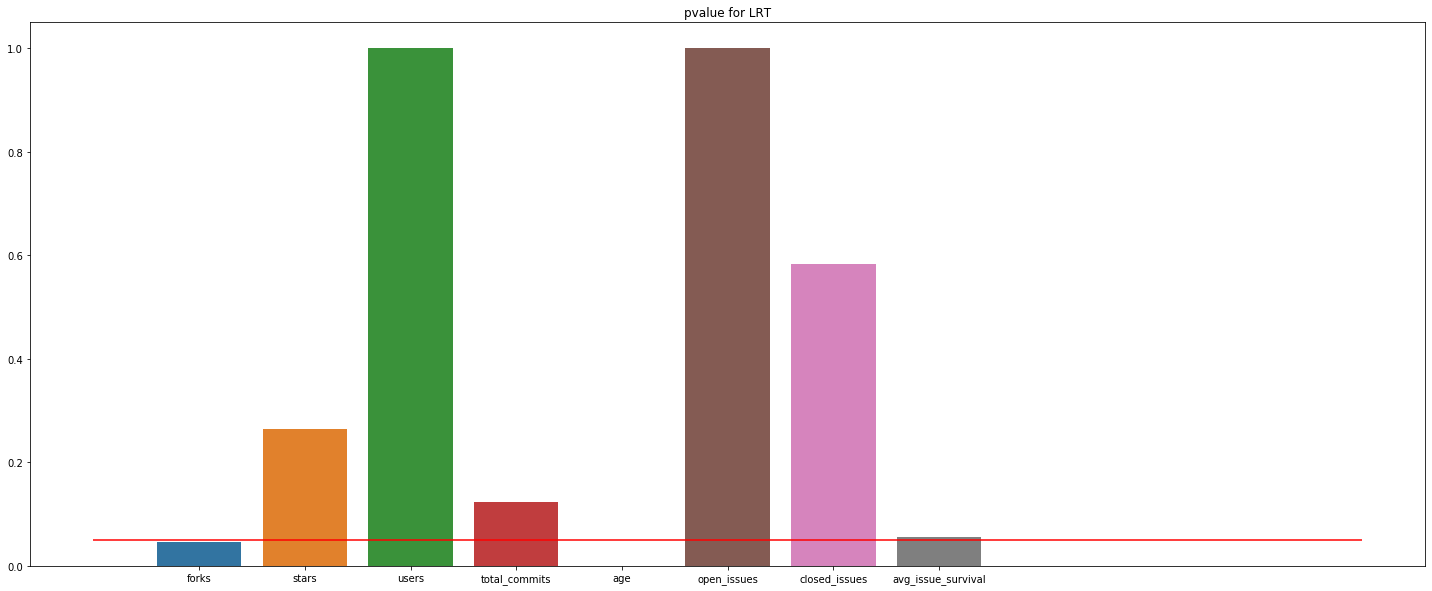

In [75]:
from scipy.stats.distributions import chi2

def experiment_regression(data, keys : list, plot=True):
    scale = StandardScaler()
    cols2drop = list(filter(lambda x: x.endswith('phi'), df.columns))
    X_res = data.drop(cols2drop + keys, axis=1).values
    X = data.drop(cols2drop, axis=1).values
    X = scale.fit_transform(X)
    X_res = scale.fit_transform(X_res)
    standardize = lambda x: (x-x.mean())/x.std()
    y = standardize(data['linear_avg_phi'].values)

    
    lr = SVR()
    lr.fit(X, y)
    pred = lr.predict(X)
    
    lr_res = SVR()
    lr_res.fit(X_res, y)
    pred_res = lr_res.predict(X_res)

    err = np.sum(np.square(y - pred))
    err_res = np.sum(np.square(y - pred_res))
    LR = err_res - err
    pvalue = chi2.sf(LR, 1)

    if plot:
        plt.figure(figsize=(20,10))
        plt.subplot(2,1,1)
        plt.title('full model')
        plt.plot(y)
        plt.plot(pred)

        plt.subplot(2,1,2)
        plt.title('restricted model')
        plt.plot(y)
        plt.plot(pred_res)
        plt.show()
    return LR, pvalue

pvalues = []
cols2drop = list(filter(lambda x: x.endswith('phi'), df.columns))
for col in df.drop(cols2drop, axis=1).columns:
    lr, p = experiment_regression(df, keys=[col], plot=False)
    pvalues += [p]
    print(col, f"pvalue={p}", 'lr={:.2f}'.format(lr))

plt.figure(figsize=(25,10))
plt.title('pvalue for LRT')
sns.barplot(x=df.drop(cols2drop, axis=1).columns, y=pvalues)
plt.hlines(y=0.05, xmin=-1, xmax=11, colors='r')
plt.show()